In [2]:
from tdmclient import ClientAsync, aw
client = ClientAsync()

In [3]:
node = aw(client.wait_for_node())

In [1]:
from VisionClass import VisionClass
from GlobalMapClass import GlobalMapClass
import ShorthestPath
from KalmanFilterClass import KalmanFilterClass
#from LocalNavigator import LocalNavigator
import motionPlanning
import numpy as np
import matplotlib.pyplot as plt
import cv2
import time

In [2]:
from tdmclient import ClientAsync, aw
import numpy as np
import math
import time

class LocalNavigator:
    def __init__(self):
        self.client = ClientAsync()
        print("Async OK")
        self.node = aw(self.client.wait_for_node())
        print("Node Ok")

        aw(self.node.lock())
        aw(self.node.wait_for_variables())

        self.dist_threshold = 2300 # 1600
        self.motor_speed = 200
        self.sensor_vals = list(self.node['prox.horizontal'])
        self.verbose = True # whether to print status message or not
        self.angle = self.val_to_angle(0) # the current rotated angle of Thymio
        self.cumulative_angle = self.val_to_angle(0) # the cumulative rotated angles
        self.turn_direction = 1 # turn right: 1, turn left: -1
        self.start = 0 # start time to rotate
        self.end = 0 # end time to rotate
        self.time = 0 # rotation time
        self.omega = 0 # rotation velocity
        """
        |Degree|Motor speed|velocity (degree/sec)|
        |------|-----------|---------------------|
        | 1080 |    300    |         108         |
        | 554  |    200    |         55          |
        | 370  |    100    |         37          |
        | 325  |    80     |         32          |
        | 222  |    50     |         22          |
        | 135  |    30     |         13          |
        """
        self.is_alter = [] # for checking whether Thymio stuck in deadlock
        self.deadlock_flag = False # whether Thymio stuck in deadlock

    def get_outputs(self):
        return (self.angle, self.cumulative_angle, self.motor_speed)

    def val_to_angle(self, val):
        return val * math.pi / 180

    def motor(self, l_speed=500, r_speed=500):
        if self.verbose:
            print("\tSetting speed: ", l_speed, r_speed)
        return {
                "motor.left.target": [l_speed],
                "motor.right.target": [r_speed],
                }

    def print_sensor_values(self):
        if self.verbose:
            print("\tSensor values (prox_horizontal): ", self.sensor_vals)

    def compute_angle(self):
        self.angle = self.turn_direction * self.omega * self.time
        self.cumulative_angle += self.angle
        if self.verbose:
            print("Rotated angle: ", self.angle)
            print("Cumulative rotated angle: ", self.cumulative_angle)

    def compute_motor_speed(self):
        max_sensor_val = max(self.sensor_vals)

        if 0 <= max_sensor_val < 1500:
            self.motor_speed = 200
            self.omega = 55
        elif 1500 <= max_sensor_val < 2000:
            self.motor_speed = 100
            self.omega = 37
        elif 2000 <= max_sensor_val < 2300:
            self.motor_speed = 80
            self.omega = 32
        elif 2300 <= max_sensor_val < 2500:
            self.motor_speed = 50
            self.omega = 22
        elif 2500 <= max_sensor_val:
            self.motor_speed = 30
            self.omega = 13

    async def check_deadlock(self):
        if len(self.is_alter) > 20 and sum(self.is_alter) == 0: # turn right and turn left alternately over 20 times
            print(">>Deadlock")
            self.deadlock_flag = True

    async def turn_left(self):
        print("Turn left")
        self.turn_direction = -1
        self.start = time.time()
        await self.node.set_variables(self.motor(-self.motor_speed, self.motor_speed))
        self.end = time.time()
        self.time = self.end - self.start
        self.is_alter.append(self.turn_direction)

    async def turn_right(self):
        print("Turn right")
        self.turn_direction = 1
        self.start = time.time()
        await self.node.set_variables(self.motor(self.motor_speed, -self.motor_speed))
        self.end = time.time()
        self.time = self.end - self.start
        self.is_alter.append(self.turn_direction)

    async def forward(self):
        self.turn_direction = 0
        await self.node.set_variables(self.motor(self.motor_speed, self.motor_speed))
        self.is_alter = [] # reset

    async def backward(self):
        self.turn_direction = 0
        await self.node.set_variables(self.motor(-self.motor_speed, -self.motor_speed))
        self.is_alter = [] # reset

    async def avoid(self, angle):
        front_prox_horizontal = self.sensor_vals[:5]
        back_prox_horizontal = self.sensor_vals[5:]

        self.print_sensor_values()

        # compute the proper motor speed according to the distance of obstacle
        self.compute_motor_speed()

        if all([x < self.dist_threshold for x in front_prox_horizontal]): # no obstacle
            print("No obstacle")
            # await self.forward()
            if angle > 1e-3:
                self.motor_speed = 100
                await self.turn_right()
            elif angle < 1e-3:
                self.motor_speed = 100
                await self.turn_left()
            else:
                self.motor_speed = 200
                await self.forward()
            self.time = 0
            self.deadlock_flag = False # free to deadlock
            self.is_alter = [] # reset

        if not self.deadlock_flag:
            if front_prox_horizontal[2] > self.dist_threshold: # front obstacle
                print("Front obstacle")
                if front_prox_horizontal[2] > 4000: # too close to the obstacle
                    await self.backward()

                if (front_prox_horizontal[1] - front_prox_horizontal[3]) < -100: # close to right
                    await self.turn_left()
                elif (front_prox_horizontal[1] - front_prox_horizontal[3]) < 100: # close to left
                    await self.turn_right()
                else:
                    if np.random.randint(20) < 1: # probability 0.05
                        print(">> Explore!")
                        await self.turn_left()
                    else: # probability 0.95
                        await self.turn_right()

            elif any([x > self.dist_threshold for x in front_prox_horizontal[:2]]): # left obstacle
                print("Left obstacle")
                await self.turn_right()

            elif any([x > self.dist_threshold for x in front_prox_horizontal[3:]]): # right obstacle
                print("Right obstacle")
                await self.turn_left()

            elif any([x > self.dist_threshold for x in back_prox_horizontal]): # back obstacle
                print("Back obstacle")
                await self.forward()
                self.time = 0
        else: # in deadlock situation
            await self.turn_right() # turn right until there is no obstacle

        # compute Thymio's rotated direction (angle)
        self.compute_angle()

        # check whether Thymio stuck in deadlock
        await self.check_deadlock()

    async def run(self, angle):
        # print(chr(27) + "[2J") # clear terminal
        # await self.client.sleep(0.1)
        print("===============================================")
        self.sensor_vals = list(self.node['prox.horizontal'])
        await self.avoid(angle)

# if __name__ == "__main__":
#     local_naviagtor = LocalNavigator()
#     aw(local_naviagtor.run())
#     aw(local_naviagtor.node.unlock())


In [2]:
mapSize=(139,90)
globalMap=GlobalMapClass()
globalMap.setMapSize(mapSize[0],mapSize[1])
kalmanFilter=KalmanFilterClass()
vision=VisionClass(mapSize, handCalibration=True)

In [3]:
robot=LocalNavigator()

Async OK


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\bapti\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\interactiveshell.py", line 3441, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\bapti\AppData\Local\Temp/ipykernel_18816/2550114492.py", line 1, in <module>
    robot=LocalNavigator()
  File "C:\Users\bapti\AppData\Local\Temp/ipykernel_18816/3852191345.py", line 10, in __init__
    self.node = aw(self.client.wait_for_node())
  File "C:\Users\bapti\AppData\Local\Programs\Python\Python39\lib\site-packages\tdmclient\clientasync.py", line 168, in aw
    ClientAsync.run_async_program(prog)
  File "C:\Users\bapti\AppData\Local\Programs\Python\Python39\lib\site-packages\tdmclient\clientasync.py", line 153, in run_async_program
    co.send(None)
  File "C:\Users\bapti\AppData\Local\Programs\Python\Python39\lib\site-packages\tdmclient\clientasync.py", line 166, in prog
    r = await co
  File "C:\Users\bapti\AppData\Local\Programs\Py

TypeError: object of type 'NoneType' has no len()

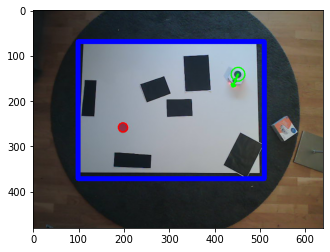

In [3]:
flag=False
vision.initialize()
time.sleep(5) #to get the of the camera done

while(not flag):
    flag=True
    vision.update()
    flag&=vision.Size()
    flag&=globalMap.setRobot(vision.robotDetection())
    flag&=globalMap.setGoal(vision.goalDetection())
    globalMap.setObstacles(vision.obstaclesDetection(True))
    plt.imshow(cv2.cvtColor(vision.imageDraw,cv2.COLOR_BGR2RGB))
    


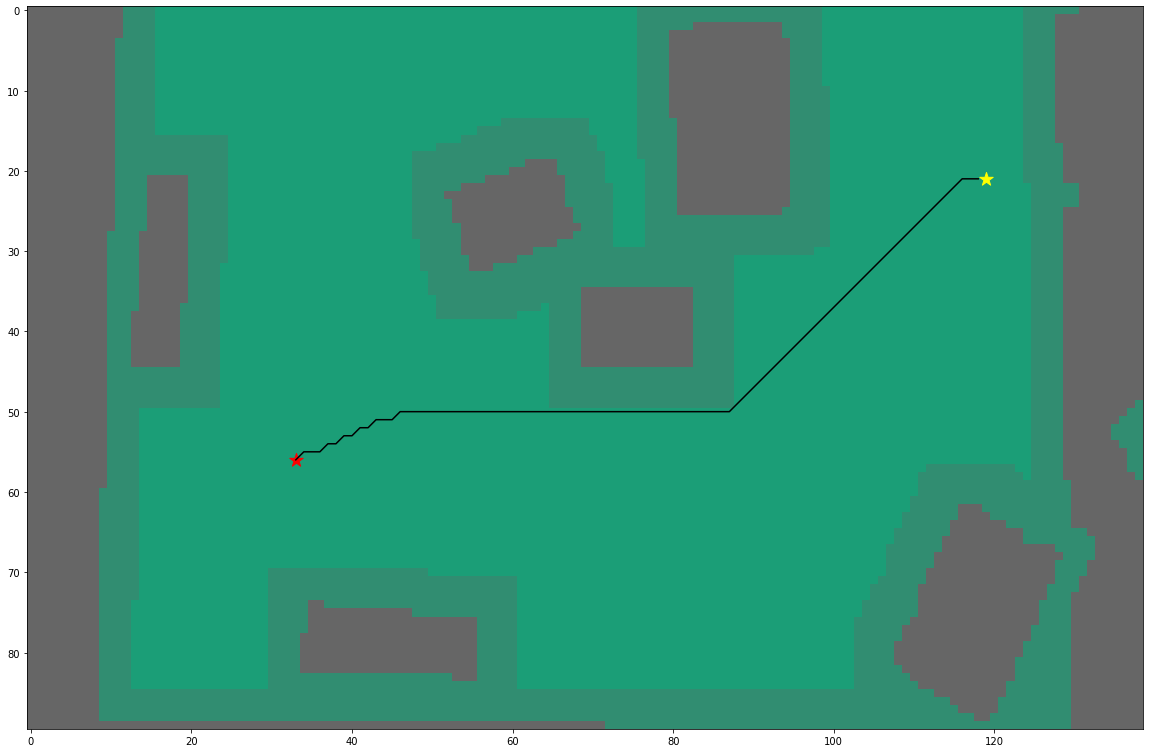

In [4]:
route=ShorthestPath.astar(globalMap.getObstacles(),globalMap.getMapSize()[0], globalMap.getMapSize()[1], 
                          globalMap.getRobot(), globalMap.getGoal())
globalMap.setPath(route)

x_coords = []
y_coords = []
for i in (range(0,len(route))):
    x = route[i][0]
    y = route[i][1]
    x_coords.append(x)
    y_coords.append(y)

# plot map and path
fig, ax = plt.subplots(figsize=(20,20))
ax = plt.gca()
ax.invert_yaxis()
ax.imshow(vision.obstaclesDetection(False), cmap=plt.cm.Dark2)
ax.imshow(globalMap.getObstacles(), cmap=plt.cm.Dark2, alpha=0.3)
ax.scatter(globalMap.getRobot()[0],globalMap.getRobot()[1], marker = "*", color = "yellow", s = 200)
ax.scatter(globalMap.getGoal()[0],globalMap.getGoal()[1], marker = "*", color = "red", s = 200)
ax.plot(y_coords,x_coords, color = "black")
plt.show()

In [7]:
print(globalMap.getGoal())
print(vision.goalDetection())
print(globalMap.getRobot())
print(vision.robotDetection())

[27, 28]
[27, 28]
[122, 21, 0]
[122, 21, 10]


In [ ]:
while(True):
    vision.update()
    globalMap.setRobot(vision.robotDetection())
    robot.run(motionPlanning.getMotionAnlge(globalMap.getPath(),globalMap.getRobot()))

In [5]:
print(motionPlanning.getMotionAngle(globalMap.getPath(),globalMap.getRobot()))

IndexError: list index out of range

In [6]:
import motionPlanning

In [ ]:
robot.run(motionPlanning.getMotionAnlge(globalMap.getPath(),globalMap.getRobot()))